In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying tennis.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/tennis.bin
copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/pyth

copying chopper_command.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Chopper Command (1982) (Activision, Bob Whitehead) (AX-015, AX-015-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/chopper_command.bin
copying time_pilot.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Time Pilot (1983) (Coleco - Woodside Design Associates, Harley H. Puthuff Jr.) (2663) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/time_pilot.bin
copying adventure.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/adventure.bin
copying solaris.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Solaris (The Last Starfighter, Star Raiders II, Universe) (1986) (Atari, Douglas Neubauer, Mimi Nyden) (CX26136)

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 400 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_400_1e-4.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_400_1e-4.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_3636/4046453138.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game fini

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.9805930399
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: 1.0 !!!!!!!!
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11:

ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: 1.0 !!!!!!!!
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.915658323223173
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
e

ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.914116939246856
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: ga

resetting env. episode reward total was -19.0. running mean: -20.84417642219811
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.84573465797613
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0


ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.78375084196894
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: gam

ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.77541424724197
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: 1.0 !!!!!!!!
ep

ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: 1.0 !!!!!!!!
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.72010520088517
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: 1.0 !!!!!!!!
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward:

ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.681235600941946
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: ga

ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.62338695756742
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
resetting env. episode reward total was -21.0

ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.602032013292085
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: ga

ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: 1.0 !!!!!!!!
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.592707182982654
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: gam

ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.54018369992032
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finishe

ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.516602024938987
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finish

ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.529680978904032
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: 1.0 !!!!!!!!
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: gam

ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.49777430033721
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finishe

ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.526965525638147
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finish

ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.529539285928077
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.534243893068798
ep 167: ga

ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.545296316253236
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: 1.0 !!!!!!!!
ep 176: game finished, reward: -1.0
ep 176: gam

ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: 1.0 !!!!!!!!
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.53072604630412
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: 1.0 !!!!!!!!
ep 1

ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: 1.0 !!!!!!!!
ep 194: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.47703626377072
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game

ep 203: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.453825162172997
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: 1.0 !!!!!!!!
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.449286910551265
ep

ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
ep 213: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43897558029551
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finishe

resetting env. episode reward total was -20.0. running mean: -20.429928624423084
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.435629338178853
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: ga

ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
ep 232: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.437258963041263
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finish

ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
ep 242: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.462138646358373
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: 1.0 !!!!!!!!
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: 1.0 !!!!!!!!
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 

ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: 1.0 !!!!!!!!
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: 1.0 !!!!!!!!
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
ep 251: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.365188057604506
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: 1.0 !!!!!!!!
ep 252: game finished, reward: 1.0 !!!!!!!!
ep 252: game finished, 

ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
ep 260: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.297283911505787
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finish

resetting env. episode reward total was -20.0. running mean: -20.290603388100216
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
ep 270: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.297697354219213
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: ga

ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28128115248258
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
ep 280: game finishe

ep 288: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.295489688758998
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
ep 289: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30253479187141
ep 290: game finished, reward: -1.0
ep 290: gam

ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33449860896621
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finished, reward: -1.0
ep 299: game finishe

ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36921170946161
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finishe

ep 317: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.374552096882464
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: 1.0 !!!!!!!!
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: 1.0 !!!!!!!!
ep 318: game finished, reward: 1.0 !!!!!!!!
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: -1.0
ep 318: game finished, reward: 

ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: 1.0 !!!!!!!!
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.36764562014415
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game

ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.344794725386844
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
ep 337: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.360353745327
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished, reward: -1.0
ep 347: game finished,

ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: 1.0 !!!!!!!!
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: 1.0 !!!!!!!!
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
ep 356: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.354053304475077
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 

ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: 1.0 !!!!!!!!
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: 1.0 !!!!!!!!
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.332853297601886
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: 1.0 !!!!!!!!
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: -1.0
ep 366: game finished, reward: 

resetting env. episode reward total was -20.0. running mean: -20.332115573713203
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
ep 375: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33879441797607
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: gam

ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.357923236165337
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finished, reward: -1.0
ep 385: game finish

ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
ep 394: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.409516284008273
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finish

ep 403: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.40274822988533
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.408720747586475
ep 405: game finished, reward: -1.0
ep 405: gam

ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.431986509458447
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finish

ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.41922107737967
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finishe

ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.402281428260213
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: 1.0 !!!!!!!!
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: gam

ep 442: game finished, reward: -1.0
ep 442: game finished, reward: 1.0 !!!!!!!!
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: 1.0 !!!!!!!!
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.382154616905556
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 443: game finished, reward: -1.0
ep 

ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35832748781294
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finished, reward: -1.0
ep 452: game finishe

ep 461: game finished, reward: 1.0 !!!!!!!!
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: 1.0 !!!!!!!!
ep 461: game finished, reward: -1.0
ep 461: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.38094742697908
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 462: game finished, reward: -1.0
ep 4

ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.386159986747266
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
ep 471: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.359058452075704
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: 1.0 !!!!!!!!
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: game finished, reward: -1.0
ep 481: gam

ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34741706695474
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finished, reward: -1.0
ep 490: game finishe

ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
ep 499: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36290989297445
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finished, reward: -1.0
ep 500: game finishe

ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.370929397110615
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: 1.0 !!!!!!!!
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: game finished, reward: -1.0
ep 509: gam

ep 518: game finished, reward: 1.0 !!!!!!!!
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: 1.0 !!!!!!!!
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: -1.0
ep 518: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.335639382376534
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: -1.0
ep 519: game finished, reward: 

ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: 1.0 !!!!!!!!
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.258077987392443
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: game finished, reward: -1.0
ep 528: gam

ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22732016909681
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: 1.0 !!!!!!!!
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: 1.0 !!!!!!!!
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 5

resetting env. episode reward total was -21.0. running mean: -20.22716890319963
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.224897214167633
ep 547: game finished, reward: -1.0
ep 

ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.233116316369518
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finish

ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: 1.0 !!!!!!!!
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: 1.0 !!!!!!!!
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.248393886440784
ep 566: game finished, reward: -1.0
ep 566: game finished, reward: -1.0
ep 566: game finished, reward: -1.0
ep 566: game finished, reward: -1.0
ep 

ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26555330886149
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finishe

ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.288399166571672
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finish

ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: 1.0 !!!!!!!!
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.27247246391814
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game

resetting env. episode reward total was -19.0. running mean: -20.258602580202318
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: 1.0 !!!!!!!!
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.256016554400293
ep 604: game finished, reward: -1.0
ep

ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.245312802803436
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finish

ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.232263348406857
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: 1.0 !!!!!!!!
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23908214006151
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: 1.0 !!!!!!!!
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 6

ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.228889944647282
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finish

ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: 1.0 !!!!!!!!
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.235338547247117
ep 651: game finished, reward: -1.0
ep 651: game finished, reward: -1.0
ep 651: game finished, reward: -1.0
ep 651: game finished, reward: -1.0
ep 651: game finished, reward: -1.0
ep 651: game finished, reward: -1.0
ep 651: gam

ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: 1.0 !!!!!!!!
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.204701515872195
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: gam

ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: 1.0 !!!!!!!!
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: 1.0 !!!!!!!!
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.21299603902986
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 6

ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: 1.0 !!!!!!!!
ep 678: game finished, reward: 1.0 !!!!!!!!
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.212627704236763
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 

ep 687: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2141429175942
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.222001488418258
ep 689: game finished, reward: -1.0
ep 689: game

ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25142980221619
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: 1.0 !!!!!!!!
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game

ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27524565677068
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finishe

ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.223008169290843
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: 1.0 !!!!!!!!
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: gam

ep 725: game finished, reward: -1.0
ep 725: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.213915859073943
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.221776700483204
ep 727: ga

ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.212593017616207
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: 1.0 !!!!!!!!
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: gam

ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
ep 744: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.204001536892992
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finish

ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.232165029793176
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: 1.0 !!!!!!!!
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: gam

ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
ep 763: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.192879769569675
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finish

ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: 1.0 !!!!!!!!
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
ep 773: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.182314524277565
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 

ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
ep 782: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.224684976472396
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: 1.0 !!!!!!!!
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: gam

ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
resetting env. e

ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15989584242185
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finishe

ep 810: game finished, reward: -1.0
ep 810: game finished, reward: -1.0
ep 810: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.17528721540356
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: 1.0 !!!!!!!!
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18745884766502
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game

ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.190959477471736
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.210356293032476
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: 

ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.201300370240176
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finish

ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18340520055006
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finishe

ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
ep 867: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.225385259538896
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.202512572890384
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finish

ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.203928224216924
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: 1.0 !!!!!!!!
ep 887: game finished, reward: -1.0
ep 887: gam

ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: 1.0 !!!!!!!!
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: 1.0 !!!!!!!!
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.19459796512912
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 8

ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22523554849302
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, r

ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.216259547861252
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finish

ep 924: game finished, reward: 1.0 !!!!!!!!
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22552266922063
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: 1.0 !!!!!!!!
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 9

ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: 1.0 !!!!!!!!
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.203558904600005
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: gam

ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
ep 943: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21488313420905
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finishe

ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.252096329859274
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finish

ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2692217928891
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: 1.0 !!!!!!!!
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: 1.0 !!!!!!!!
ep 963: game finished, reward: -1.0
ep 96

ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31150629025309
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finished, reward: -1.0
ep 973: game finishe

ep 981: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.27446933894584
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28172464555638
ep 983: game finished, reward: -1.0
ep 9

ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.276974065341037
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finished, reward: -1.0
ep 992: game finish

ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.251486398211064
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward: -1.0
ep 1001: game finished, reward:

ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.239347906334565
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
ep 1010: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.246

ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: 1.0 !!!!!!!!
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.273352267591992
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished, reward: -1.0
ep 1020: game finished,

ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.278351348527323
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward: -1.0
ep 1029: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.292135866777333
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
ep 1038: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29921450810956
ep 1039: game finished, reward: -1.0
ep 1039: game finished, r

ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: 1.0 !!!!!!!!
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
ep 1047: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.292739672960412
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished, reward: -1.0
ep 1048: game finished,

ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.315764038311347
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: 1.0 !!!!!!!!
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished, reward: -1.0
ep 1057: game finished,

ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.298159777017563
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
ep 1066: game finished, reward: -1.0
resetting env. episode 

ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.297720868237434
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward: -1.0
ep 1076: game finished, reward:

ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
ep 1084: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31002247364279
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: 1.0 !!!!!!!!
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, reward: -1.0
ep 1085: game finished, 

ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29184932175331
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: 1.0 !!!!!!!!
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, reward: -1.0
ep 1094: game finished, 

resetting env. episode reward total was -19.0. running mean: -20.294945903166123
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: 1.0 !!!!!!!!
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
ep 1103: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.291996444134462
ep 1104: game fi

ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
ep 1112: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.286541954555513
ep 1113: game finished, reward: -1.0
ep 1113: game finished, reward: -1.0
ep 1113: game finished, reward: -1.0
ep 1113: game finished, reward: -1.0
ep 1113: game finished, reward: -1.0
ep 1113: game finished, reward:

ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28107975950714
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: -1.0
ep 1122: game finished, reward: 

ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.256877835064657
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward: -1.0
ep 1131: game finished, reward:

ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20458303482083
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: -1.0
ep 1140: game finished, reward: 

ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.234651121773723
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: 1.0 !!!!!!!!
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished, reward: -1.0
ep 1149: game finished,

ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
ep 1158: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.231534921891928
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward: -1.0
ep 1159: game finished, reward:

ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19268932502024
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: -1.0
ep 1168: game finished, reward: 

ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: 1.0 !!!!!!!!
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.146621923697026
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished, reward: -1.0
ep 1177: game finished,

ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: 1.0 !!!!!!!!
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: 1.0 !!!!!!!!
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.13288282618082
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game fi

ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.14975063582691
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: 1.0 !!!!!!!!
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, 

ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.173968187807304
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward: -1.0
ep 1205: game finished, reward:

ep 1213: game finished, reward: 1.0 !!!!!!!!
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: 1.0 !!!!!!!!
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.18627824564753
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: 1.0 !!!!!!!!
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214:

ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: 1.0 !!!!!!!!
ep 1222: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.171029142376867
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished,

ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.165667458726883
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward:

ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: 1.0 !!!!!!!!
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.19700820803177
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, reward: -1.0
ep 1242: game finished, 

ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22792254546121
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: 

ep 1259: game finished, reward: 1.0 !!!!!!!!
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.227042573909483
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished,

ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25339876511278
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: 

ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.21342403505649
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, 

ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20467543755066
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: 1.0 !!!!!!!!
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, 

ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.226848340443247
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: 1.0 !!!!!!!!
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished,

resetting env. episode reward total was -20.0. running mean: -20.245754623151957
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: 1.0 !!!!!!!!
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.243297076920435
ep 1307: game fi

ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: 1.0 !!!!!!!!
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.202847038596378
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game f

ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: 1.0 !!!!!!!!
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21432586390904
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, 

ep 1333: game finished, reward: -1.0
ep 1333: game finished, reward: -1.0
ep 1333: game finished, reward: -1.0
ep 1333: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25383468080602
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.242366528811942
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.249942863523824
ep 1344: game finished, reward: -1.0
ep 1344: game finished, 

ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
ep 1352: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.227266424753758
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward:

ep 1361: game finished, reward: 1.0 !!!!!!!!
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
ep 1361: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24537570070386
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: 1.0 !!!!!!!!
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: 1.0 !!!!!!!!
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: 1.0 !!!!!!!!


ep 1370: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.263827899445605
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27118962045115
ep 1372: game finished, r

ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: 1.0 !!!!!!!!
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.286642600769397
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished,

ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: 1.0 !!!!!!!!
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
ep 1389: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.251467644126635
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished,

ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: 1.0 !!!!!!!!
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
ep 1398: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.24786737556584
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: 1.0 !!!!!!!!
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game fi

ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
ep 1407: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.226721281273885
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward:

ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: 1.0 !!!!!!!!
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.243483873210778
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished,

ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: 1.0 !!!!!!!!
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: 1.0 !!!!!!!!
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.250954409655176
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: 1.0 !!!!!!!!
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427

ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
ep 1435: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.247891596625156
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: 1.0 !!!!!!!!
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: 1.0 !!!!!!!!
ep 1436: game finished, reward: 1.0 !!!!!!!!
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436

ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
ep 1444: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23789339562583
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: 

ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.263287900390548
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward:

ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.260225006488326
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward:

ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: 1.0 !!!!!!!!
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.237521992249636
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: 1.0 !!!!!!!!
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game f

ep 1481: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256004020950797
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26344398074129
ep 1483: game finished, r

ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27055567024993
ep 1492: game finished, reward: -1.0
ep 1492: game finished, reward: 1.0 !!!!!!!!
ep 1492: game finished, reward: -1.0
ep 1492: game finished, reward: -1.0
ep 1492: game finished, reward: -1.0
ep 1492: game finished, reward: -1.0
ep 1492: game finished, 

ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.27568213980561
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: 

ep 1509: game finished, reward: -1.0
ep 1509: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.289695528472908
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: 1.0 !!!!!!!!
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: 1.0 !!!!!!!!
ep 1510: game finished, reward: 1.0 !!!!!!!!
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510

resetting env. episode reward total was -21.0. running mean: -20.246484938486343
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25402008910148
ep 1520: game finished, reward: -1.0
ep 1520: game finished, r

ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: 1.0 !!!!!!!!
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: 1.0 !!!!!!!!
ep 1528: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26990679312488
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game fi

ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28529602530665
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: 1.0 !!!!!!!!
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.29964158224021
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30664516641781
ep 1548: game finished, reward: -1.0
ep 1548: game finished, re

ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.347966152458234
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: 1.0 !!!!!!!!
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished,

ep 1565: game finished, reward: 1.0 !!!!!!!!
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.328063220716107
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: 1.0 !!!!!!!!
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game f

ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28164017323106
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: 1.0 !!!!!!!!
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, 

ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.312274285294897
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward: -1.0
ep 1585: game finished, reward:

ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.25538542329685
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, 

ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.242815721521648
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward:

ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21297803261207
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: 1.0 !!!!!!!!
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, 

ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.224343657795927
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.23300665307651
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: 1.0 !!!!!!!!
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: 1.0 !!!!!!!!
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22148412406115
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: 

ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.17255094610301
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: 

ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.205384384372014
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward:

ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
ep 1666: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.187821099266795
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: 1.0 !!!!!!!!
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished,

ep 1675: game finished, reward: -1.0
ep 1675: game finished, reward: -1.0
ep 1675: game finished, reward: -1.0
ep 1675: game finished, reward: -1.0
ep 1675: game finished, reward: -1.0
ep 1675: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.172739505582264
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward:

ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: 1.0 !!!!!!!!
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
ep 1685: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22281967589167
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, 

ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: 1.0 !!!!!!!!
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
ep 1694: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18565862130779
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, 

ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
ep 1703: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18056015387141
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: 1.0 !!!!!!!!
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: 1.0 !!!!!!!!
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: 1.0 !!!!!!!!
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704: game finished, reward: -1.0
ep 1704:

ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
ep 1712: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.137167414335998
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: 1.0 !!!!!!!!
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished, reward: -1.0
ep 1713: game finished,

ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
ep 1721: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.12588816333841
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: 1.0 !!!!!!!!
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: 1.0 !!!!!!!!
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game finished, reward: -1.0
ep 1722: game fi

ep 1730: game finished, reward: -1.0
ep 1730: game finished, reward: -1.0
ep 1730: game finished, reward: -1.0
ep 1730: game finished, reward: -1.0
ep 1730: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.105188363013404
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: 1.0 !!!!!!!!
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished, reward: -1.0
ep 1731: game finished,

ep 1739: game finished, reward: -1.0
ep 1739: game finished, reward: -1.0
ep 1739: game finished, reward: -1.0
ep 1739: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.088407014394626
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward: -1.0
ep 1740: game finished, reward:

ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: 1.0 !!!!!!!!
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
ep 1749: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.098594968732172
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished, reward: -1.0
ep 1750: game finished,

ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
ep 1758: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.137638036768312
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: 1.0 !!!!!!!!
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished,

resetting env. episode reward total was -21.0. running mean: -20.173586036069725
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: 1.0 !!!!!!!!
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: 1.0 !!!!!!!!
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: 1.0 !!!!!!!!
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
resetti

ep 1776: game finished, reward: -1.0
ep 1776: game finished, reward: -1.0
ep 1776: game finished, reward: -1.0
ep 1776: game finished, reward: 1.0 !!!!!!!!
ep 1776: game finished, reward: 1.0 !!!!!!!!
ep 1776: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.081484479010378
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game f

ep 1785: game finished, reward: -1.0
ep 1785: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.094330577064337
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: 1.0 !!!!!!!!
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
resetting env. episode 

ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: 1.0 !!!!!!!!
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: 1.0 !!!!!!!!
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.083766883944566
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game finished, reward: -1.0
ep 1796: game f

ep 1804: game finished, reward: 1.0 !!!!!!!!
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.076625297307583
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished, reward: -1.0
ep 1805: game finished,

ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04992303614226
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: -1.0
ep 1814: game finished, reward: 

ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: 1.0 !!!!!!!!
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.074140078640777
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished, reward: -1.0
ep 1823: game finished,

ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.067160578507437
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: 1.0 !!!!!!!!
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished, reward: -1.0
ep 1832: game finished,

resetting env. episode reward total was -21.0. running mean: -20.081730781752395
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.090913473934872
ep 1842: game finished, reward: -1.0
ep 1842: game finished, 

ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: 1.0 !!!!!!!!
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
ep 1850: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.093130656657674
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: 1.0 !!!!!!!!
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game finished, reward: -1.0
ep 1851: game f

ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: -1.0
ep 1859: game finished, reward: 1.0 !!!!!!!!
ep 1859: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.085271481717307
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished, reward: -1.0
ep 1860: game finished,

ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: 1.0 !!!!!!!!
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: 1.0 !!!!!!!!
ep 1868: game finished, reward: -1.0
ep 1868: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.076533366311526
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869: game finished, reward: -1.0
ep 1869

ep 1877: game finished, reward: 1.0 !!!!!!!!
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: 1.0 !!!!!!!!
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
ep 1877: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.038569561055912
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: 1.0 !!!!!!!!
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: -1.0
ep 1878: game finished, reward: 1.0 !!!!!!!!
ep 1878: game finished, reward: -1.0

ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
ep 1886: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.02648402546389
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: 1.0 !!!!!!!!
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, reward: -1.0
ep 1887: game finished, 

ep 1895: game finished, reward: -1.0
ep 1895: game finished, reward: -1.0
ep 1895: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04438186047885
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: 1.0 !!!!!!!!
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, reward: -1.0
ep 1896: game finished, 

ep 1904: game finished, reward: -1.0
ep 1904: game finished, reward: -1.0
ep 1904: game finished, reward: -1.0
ep 1904: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.002400228959715
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished, reward: -1.0
ep 1905: game finished,

ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: -1.0
ep 1913: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.9722209391899
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
ep 1914: game finished, reward: -1.0
resetting env. episode reward tot

ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: 1.0 !!!!!!!!
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: 1.0 !!!!!!!!
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: 1.0 !!!!!!!!
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
ep 1923: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.964117963663885
ep 1924

ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
ep 1932: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.01556338996147
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: -1.0
ep 1933: game finished, reward: 

ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: 1.0 !!!!!!!!
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
ep 1941: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.022759673597402
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: 1.0 !!!!!!!!
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game finished, reward: -1.0
ep 1942: game f

ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
ep 1950: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.982274444178326
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward: -1.0
ep 1951: game finished, reward:

ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: -1.0
ep 1959: game finished, reward: 1.0 !!!!!!!!
ep 1959: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.965370777433712
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished, reward: -1.0
ep 1960: game finished,

ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
ep 1968: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97827534178296
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: -1.0
ep 1969: game finished, reward: 

ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
ep 1977: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.969297280346403
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward: -1.0
ep 1978: game finished, reward:

ep 1986: game finished, reward: -1.0
ep 1986: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.972820071078697
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
ep 1987: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.983

ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: 1.0 !!!!!!!!
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.97437452088475
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game fi

ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.005037891391478
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward: -1.0
ep 2006: game finished, reward:

ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: 1.0 !!!!!!!!
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: 1.0 !!!!!!!!
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.92629108413929
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game finished, reward: -1.0
ep 2015: game fi

ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: 1.0 !!!!!!!!
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.913542981179898
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished, reward: -1.0
ep 2024: game finished,

ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.892387565496538
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished, reward: -1.0
ep 2033: game finished,

ep 2041: game finished, reward: 1.0 !!!!!!!!
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: 1.0 !!!!!!!!
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.891414613367726
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: 1.0 !!!!!!!!
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042: game finished, reward: -1.0
ep 2042

ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.911465333693197
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward: -1.0
ep 2051: game finished, reward:

ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: 1.0 !!!!!!!!
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.869444424057868
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished, reward: -1.0
ep 2060: game finished,

ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.814145656196477
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward: -1.0
ep 2069: game finished, reward:

ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.849733555379938
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: 1.0 !!!!!!!!
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: 1.0 !!!!!!!!
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game finished, reward: -1.0
ep 2078: game f

ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: 1.0 !!!!!!!!
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: 1.0 !!!!!!!!
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.84340361210605
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: 1.0 !!!!!!!!
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087: game finished, reward: -1.0
ep 2087:

ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88539282433732
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: -1.0
ep 2096: game finished, reward: 1.0 !!!!!!!!
ep 2096: game finished, reward: -1.0
resetting env. episode r

ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: 1.0 !!!!!!!!
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
ep 2105: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.924881986756294
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished, reward: -1.0
ep 2106: game finished,

ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: 1.0 !!!!!!!!
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93185969681614
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, reward: -1.0
ep 2115: game finished, 

ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: 1.0 !!!!!!!!
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.985410766830068
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished, reward: -1.0
ep 2124: game finished,

ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.985506949429933
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!
ep 2133: game finished, reward: -1.0
ep 2133: game finished, reward: 1.0 !!!!!!!!

ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.928889818996765
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: 1.0 !!!!!!!!
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game f

ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.926010098607787
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: 1.0 !!!!!!!!
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished,

ep 2159: game finished, reward: 1.0 !!!!!!!!
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92213148371168
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: 1.0 !!!!!!!!
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: 1.0 !!!!!!!!
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160:

ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89975207228339
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 

ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.841564307689566
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: 1.0 !!!!!!!!
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: 1.0 !!!!!!!!
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game f

ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
ep 2186: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.807226856104183
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward:

ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: 1.0 !!!!!!!!
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
ep 2195: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.82284450862287
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, 

ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: 1.0 !!!!!!!!
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: 1.0 !!!!!!!!
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
ep 2204: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.789258158786833
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game f

ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
ep 2213: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.779345062567497
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward:

ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: 1.0 !!!!!!!!
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
ep 2222: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.74017198698971
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, reward: -1.0
ep 2223: game finished, 

ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: 1.0 !!!!!!!!
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: 1.0 !!!!!!!!
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
ep 2231: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.73304352061485
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game finished, reward: -1.0
ep 2232: game fi

ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
ep 2240: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.794947609882957
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward: -1.0
ep 2241: game finished, reward:

ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: 1.0 !!!!!!!!
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
ep 2250: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.862318050293343
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished,

ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: 1.0 !!!!!!!!
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: -1.0
ep 2259: game finished, reward: 1.0 !!!!!!!!
ep 2259: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.87355259132007
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game finished, reward: -1.0
ep 2260: game fi

ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
ep 2268: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.912532516344353
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward: -1.0
ep 2269: game finished, reward:

ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
ep 2277: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.863809988796675
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward: -1.0
ep 2278: game finished, reward:

ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
ep 2286: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.837258413146717
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward: -1.0
ep 2287: game finished, reward:

ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
ep 2295: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.81252276382567
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: -1.0
ep 2296: game finished, reward: 

ep 2304: game finished, reward: 1.0 !!!!!!!!
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: 1.0 !!!!!!!!
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
ep 2304: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.81805319987199
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game finished, reward: -1.0
ep 2305: game fi

ep 2313: game finished, reward: 1.0 !!!!!!!!
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
ep 2313: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.813029560680953
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished, reward: -1.0
ep 2314: game finished,

ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: -1.0
ep 2322: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.771462510376704
ep 2323: game finished, reward: -1.0
ep 2323: game finished, reward: -1.0
ep 2323: game finished, reward: -1.0
ep 2323: game finished, reward: -1.0
ep 2323: game finished, reward: -1.0
ep 2323: game finished, reward: -1.0
ep 2323: game finished,

ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
ep 2331: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.830916358153438
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: 1.0 !!!!!!!!
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished, reward: -1.0
ep 2332: game finished,

ep 2340: game finished, reward: 1.0 !!!!!!!!
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: -1.0
ep 2340: game finished, reward: 1.0 !!!!!!!!
ep 2340: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.79630888709234
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game finished, reward: -1.0
ep 2341: game fi

ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: -1.0
ep 2349: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.842934722333506
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
ep 2350: game finished, reward: -1.0
resetting env. episode 

ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
ep 2359: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.9250295963052
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -1.0
ep 2360: game finished, reward: -

ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: -1.0
ep 2368: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.939966303697343
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished, reward: -1.0
ep 2369: game finished,

ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: 1.0 !!!!!!!!
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
ep 2377: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.955632706352045
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: 1.0 !!!!!!!!
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game finished, reward: -1.0
ep 2378: game f

resetting env. episode reward total was -19.0. running mean: -19.987419037600503
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
ep 2387: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.9975448472245
ep 2388: game finished, reward: -1.0
ep 2388: game finished, re

resetting env. episode reward total was -20.0. running mean: -19.950374275030317
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: 1.0 !!!!!!!!
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: 1.0 !!!!!!!!
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
ep 2396: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: 1.0 !!!!!!!!
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
ep 2405: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.963558003819628
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished, reward: -1.0
ep 2406: game finished,

ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: 1.0 !!!!!!!!
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
ep 2414: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.005428458555492
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished, reward: -1.0
ep 2415: game finished,

ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
ep 2423: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.03349832796097
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: 1.0 !!!!!!!!
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, reward: -1.0
ep 2424: game finished, 

ep 2432: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.02943872542729
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: 1.0 !!!!!!!!
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
ep 2433: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: 1.0 !!!!!!!!
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: 1.0 !!!!!!!!
ep 2442: game finished, reward: -1.0
ep 2442: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.025929060736285
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game finished, reward: -1.0
ep 2443: game f

resetting env. episode reward total was -20.0. running mean: -19.965595319546836
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: 1.0 !!!!!!!!
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
ep 2451: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.965939366351368
ep 2452: game fi

ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
ep 2460: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.979347087942
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1.0
ep 2461: game finished, reward: -1

ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: 1.0 !!!!!!!!
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
ep 2469: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.990155960218264
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished, reward: -1.0
ep 2470: game finished,

ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: 1.0 !!!!!!!!
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
ep 2478: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.971784734809336
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: 1.0 !!!!!!!!
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game finished, reward: -1.0
ep 2479: game f

ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
ep 2487: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.993054472185076
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward: -1.0
ep 2488: game finished, reward:

ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: 1.0 !!!!!!!!
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
ep 2496: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.964836202616404
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished, reward: -1.0
ep 2497: game finished,

ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: 1.0 !!!!!!!!
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
ep 2505: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.911484496124142
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished, reward: -1.0
ep 2506: game finished,

ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
ep 2514: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.851882284867624
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward: -1.0
ep 2515: game finished, reward:

ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
ep 2523: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.87421444851798
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: -1.0
ep 2524: game finished, reward: 1.0 !!!!!!!!
ep 2524: game finished, 

ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
ep 2532: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.885105412715998
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward: -1.0
ep 2533: game finished, reward:

ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
ep 2541: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.837211954836796
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward: -1.0
ep 2542: game finished, reward:

ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: -1.0
ep 2550: game finished, reward: 1.0 !!!!!!!!
ep 2550: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.851289391473216
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: 1.0 !!!!!!!!
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: 1.0 !!!!!!!!
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551: game finished, reward: -1.0
ep 2551

ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: 1.0 !!!!!!!!
ep 2559: game finished, reward: -1.0
ep 2559: game finished, reward: 1.0 !!!!!!!!
ep 2559: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.835015936783723
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game finished, reward: -1.0
ep 2560: game f

resetting env. episode reward total was -20.0. running mean: -19.87782163796408
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: 1.0 !!!!!!!!
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
ep 2569: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.879043421584438
ep 2570: game fin

ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.840444543937807
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: 1.0 !!!!!!!!
ep 2578: game finished, reward: 1.0 !!!!!!!!
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game finished, reward: -1.0
ep 2578: game f

ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: 1.0 !!!!!!!!
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: 1.0 !!!!!!!!
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.768228268986558
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game finished, reward: -1.0
ep 2587: game f

ep 2595: game finished, reward: 1.0 !!!!!!!!
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.75945073524208
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, reward: -1.0
ep 2596: game finished, 

ep 2604: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.808991522847215
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: 1.0 !!!!!!!!
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: 1.0 !!!!!!!!
resetting env. 

ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.77667715277601
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: 

ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.776482758284885
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward:

ep 2631: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.79571503705348
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: 1.0 !!!!!!!!
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: 1.0 !!!!!!!!
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.826480851579504
ep 2642: game finished, reward: -1.0
ep 2642: game finished, reward: -1.0
ep 2642: game finished, reward: -1.0
ep 2642: game finished, reward: -1.0
ep 2642: game finished,

ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.813608972830306
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward:

ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.72045830400816
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: 1.0 !!!!!!!!
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: 1.0 !!!!!!!!
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game fi

ep 2667: game finished, reward: -1.0
ep 2667: game finished, reward: -1.0
ep 2667: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.736665026904273
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: 1.0 !!!!!!!!
ep 2668: game finished, reward: -1.0
ep 2668: game finished,

ep 2676: game finished, reward: -1.0
ep 2676: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.748650958825362
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.761

ep 2685: game finished, reward: 1.0 !!!!!!!!
ep 2685: game finished, reward: -1.0
ep 2685: game finished, reward: -1.0
ep 2685: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.71283198214762
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: 1.0 !!!!!!!!
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686:

ep 2694: game finished, reward: -1.0
ep 2694: game finished, reward: -1.0
ep 2694: game finished, reward: -1.0
ep 2694: game finished, reward: -1.0
ep 2694: game finished, reward: -1.0
ep 2694: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.68010309242895
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: 1.0 !!!!!!!!
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, reward: -1.0
ep 2695: game finished, 

ep 2703: game finished, reward: -1.0
ep 2703: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.697777381093253
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
ep 2704: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean:

ep 2712: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.713345832093285
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
ep 2713: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.726212373772352
ep 2714: game finished, 

ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
ep 2722: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.788523766166524
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: -1.0
ep 2723: game finished, reward: 1.0 !!!!!!!!
ep 2723: game finished, reward: -1.0
ep 2723: game finished,

ep 2731: game finished, reward: 1.0 !!!!!!!!
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: 1.0 !!!!!!!!
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
ep 2731: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.76894108895782
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game finished, reward: -1.0
ep 2732: game fi

ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
ep 2740: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.77020086996033
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: 1.0 !!!!!!!!
ep 2741: game finished, reward: -1.0
ep 2741: game finished, reward: -1.0
ep 2741: game finished, 

ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: 1.0 !!!!!!!!
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: 1.0 !!!!!!!!
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: 1.0 !!!!!!!!
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
ep 2749: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.730667659366972
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750: game finished, reward: -1.0
ep 2750

ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: 1.0 !!!!!!!!
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: -1.0
ep 2758: game finished, reward: 1.0 !!!!!!!!
ep 2758: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.725219032397256
ep 2759: game finished, reward: -1.0
ep 2759: game finished, reward: -1.0
ep 2759: game finished, reward: -1.0
ep 2759: game finished, reward: 1.0 !!!!!!!!
ep 2759: game finished, reward: -1.0
ep 2759: game finished, reward: -1.0
ep 2759

ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: 1.0 !!!!!!!!
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
ep 2767: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.75051425954702
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, reward: -1.0
ep 2768: game finished, 

ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: 1.0 !!!!!!!!
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
ep 2776: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.7338529785209
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, reward: -1.0
ep 2777: game finished, r

ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
ep 2785: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78579186710645
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: 1.0 !!!!!!!!
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: 1.0 !!!!!!!!
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game finished, reward: -1.0
ep 2786: game fi

ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: 1.0 !!!!!!!!
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
ep 2794: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.71878936231576
ep 2795: game finished, reward: -1.0
ep 2795: game finished, reward: -1.0
ep 2795: game finished, reward: 1.0 !!!!!!!!
ep 2795: game finished, reward: -1.0
ep 2795: game finished, reward: -1.0
ep 2795: game finished, reward: -1.0
ep 2795: game finished, reward: 1.0 !!!!!!!!
ep 2795: game finished, reward: -1.0
ep 2795:

ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
ep 2803: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.697555333017966
ep 2804: game finished, reward: -1.0
ep 2804: game finished, reward: -1.0
ep 2804: game finished, reward: -1.0
ep 2804: game finished, reward: -1.0
ep 2804: game finished, reward: -1.0
ep 2804: game finished, reward:

ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: -1.0
ep 2812: game finished, reward: 1.0 !!!!!!!!
ep 2812: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.743213639407458
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished, reward: -1.0
ep 2813: game finished,

ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
ep 2821: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.755923975235422
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward: -1.0
ep 2822: game finished, reward:

ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
ep 2830: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.767132390785306
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward: -1.0
ep 2831: game finished, reward:

ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
ep 2839: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.738965059737424
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward: -1.0
ep 2840: game finished, reward:

ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
ep 2848: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.724938830513647
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward: -1.0
ep 2849: game finished, reward:

ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: 1.0 !!!!!!!!
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: 1.0 !!!!!!!!
ep 2857: game finished, reward: -1.0
ep 2857: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.663220246913045
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game finished, reward: -1.0
ep 2858: game f

ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
ep 2866: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.712052797450784
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward: -1.0
ep 2867: game finished, reward:

ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: 1.0 !!!!!!!!
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: -1.0
ep 2875: game finished, reward: 1.0 !!!!!!!!
ep 2875: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.66027057177641
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game finished, reward: -1.0
ep 2876: game fi

ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
ep 2884: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.718477843789266
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward: -1.0
ep 2885: game finished, reward:

ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
ep 2893: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.734569623930366
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: -1.0
ep 2894: game finished, reward: 1.0 !!!!!!!!
ep 2894: game finished, reward: -1.0
ep 2894: game finished,

ep 2902: game finished, reward: 1.0 !!!!!!!!
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
ep 2902: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.699875369468298
ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
ep 2903: game finished, reward: -1.0
ep 2903: game finished,

ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: 1.0 !!!!!!!!
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
ep 2911: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.706130895393787
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished, reward: -1.0
ep 2912: game finished,

ep 2920: game finished, reward: 1.0 !!!!!!!!
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: 1.0 !!!!!!!!
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: 1.0 !!!!!!!!
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
ep 2920: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.711743455919805
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921: game finished, reward: -1.0
ep 2921

ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: -1.0
ep 2929: game finished, reward: 1.0 !!!!!!!!
ep 2929: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.671531049468843
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished, reward: -1.0
ep 2930: game finished,

ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
ep 2938: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.699954523100015
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward: -1.0
ep 2939: game finished, reward:

ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: -1.0
ep 2947: game finished, reward: 1.0 !!!!!!!!
ep 2947: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.7641455798617
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: 1.0 !!!!!!!!
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game finished, reward: -1.0
ep 2948: game fin

ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: 1.0 !!!!!!!!
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
ep 2956: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.70612397950741
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, reward: -1.0
ep 2957: game finished, 

ep 2965: game finished, reward: 1.0 !!!!!!!!
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
ep 2965: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.71204483260443
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: 1.0 !!!!!!!!
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game finished, reward: -1.0
ep 2966: game fi

ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: 1.0 !!!!!!!!
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: 1.0 !!!!!!!!
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
ep 2974: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.678416492032845
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game finished, reward: -1.0
ep 2975: game f

ep 2983: game finished, reward: 1.0 !!!!!!!!
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: 1.0 !!!!!!!!
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
ep 2983: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.647014116880655
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game finished, reward: -1.0
ep 2984: game f

ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: 1.0 !!!!!!!!
ep 2992: game finished, reward: 1.0 !!!!!!!!
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.61921265447216
ep 2993: game finished, reward: -1.0
ep 2993: game finished, reward: -1.0
ep 2993: game finished, reward: -1.0
ep 2993: game fi

ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.70134338935674
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: -1.0
ep 3002: game finished, reward: 

ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.75560453115165
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: 1.0 !!!!!!!!
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: 1.0 !!!!!!!!
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: -1.0
ep 3011: game finished, reward: 1.0 !!!!!!!!


ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.730132511659473
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward: -1.0
ep 3020: game finished, reward:

ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: 1.0 !!!!!!!!
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.7342603184231
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: 1.0 !!!!!!!!
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: 1.0 !!!!!!!!
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: game finished, reward: -1.0
ep 3029: 

ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: 1.0 !!!!!!!!
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: 1.0 !!!!!!!!
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.661812520648635
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: 1.0 !!!!!!!!
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038

ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.720561963834502
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: 1.0 !!!!!!!!
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished,

ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: 1.0 !!!!!!!!
ep 3055: game finished, reward: 1.0 !!!!!!!!
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: 1.0 !!!!!!!!
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.685906801875802
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: 1.0 !!!!!!!!
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0

ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.722982130071333
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward:

ep 3073: game finished, reward: 1.0 !!!!!!!!
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.746451093010258
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished,

resetting env. episode reward total was -21.0. running mean: -19.78750423633352
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: 1.0 !!!!!!!!
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: 1.0 !!!!!!!!
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 3091: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.776471632004267
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: 1.0 !!!!!!!!
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: 1.0 !!!!!!!!
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
resetting env. 

ep 3100: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.76638628656982
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.77872242370412
ep 3102: game finished, re

ep 3109: game finished, reward: -1.0
ep 3109: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.755927082270116
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, rewa

ep 3118: game finished, reward: 1.0 !!!!!!!!
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: -1.0
ep 3118: game finished, reward: 1.0 !!!!!!!!
ep 3118: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.72050772875391
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: 1.0 !!!!!!!!
ep 3119: game finished, reward: -1.0
ep 3119:

ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
ep 3127: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71547202957832
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: 1.0 !!!!!!!!
ep 3128: game finished, reward: 1.0 !!!!!!!!
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: 1.0 !!!!!!!!
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128:

ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
ep 3136: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.70211896684471
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: 1.0 !!!!!!!!
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, 

ep 3145: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.747002191993463
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
ep 3146: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.75953217007353
ep 3147: game finished, r

resetting env. episode reward total was -19.0. running mean: -19.757737041026836
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: 1.0 !!!!!!!!
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: 1.0 !!!!!!!!
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
ep 3155: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -20.0. running mean: -19.76005607349238
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: 1.0 !!!!!!!!
ep 3164: game finished, reward: -1.0
ep 3164: game finished, reward: -1.0
resettin

ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
ep 3173: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78309053122597
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: 

ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: 1.0 !!!!!!!!
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
ep 3182: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.783884567215054
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished,

ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: 1.0 !!!!!!!!
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
ep 3191: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.77356481608371
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, 

ep 3200: game finished, reward: 1.0 !!!!!!!!
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
ep 3200: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.792375981099617
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished, reward: -1.0
ep 3201: game finished,

ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: 1.0 !!!!!!!!
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
ep 3209: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.742316712493903
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished, reward: -1.0
ep 3210: game finished,

ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: 1.0 !!!!!!!!
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: 1.0 !!!!!!!!
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: 1.0 !!!!!!!!
ep 3218: game finished, reward: -1.0
ep 3218: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.705677336525632
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219: game finished, reward: -1.0
ep 3219

ep 3226: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.669702383729135
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: 1.0 !!!!!!!!
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
ep 3227: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 3235: game finished, reward: -1.0
ep 3235: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.6600328180448
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: 1.0 !!!!!!!!
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: -1.0
ep 3236: game finished, reward: 1.0 !!!!!!!!
ep 3236: game finished, reward: -1.0
ep 3236: game fin

ep 3244: game finished, reward: -1.0
ep 3244: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.66234757030909
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: 1.0 !!!!!!!!
ep 3245: game finished, reward: 1.0 !!!!!!!!
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: 1.0 !!!!!!!!
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245: game finished, reward: -1.0
ep 3245:

ep 3253: game finished, reward: -1.0
ep 3253: game finished, reward: -1.0
ep 3253: game finished, reward: -1.0
ep 3253: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.653003678433038
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: 1.0 !!!!!!!!
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: 1.0 !!!!!!!!
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game finished, reward: -1.0
ep 3254: game f

ep 3262: game finished, reward: -1.0
ep 3262: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.673299210874987
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: 1.0 !!!!!!!!
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
ep 3263: game finished, reward: -1.0
resetting env. episode 

ep 3271: game finished, reward: -1.0
ep 3271: game finished, reward: 1.0 !!!!!!!!
ep 3271: game finished, reward: -1.0
ep 3271: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.654384028787756
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished, reward: -1.0
ep 3272: game finished,

ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: 1.0 !!!!!!!!
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: 1.0 !!!!!!!!
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
ep 3281: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.715485074767734
ep 3282: game finished, reward: -1.0
ep 3282: game finished, reward: -1.0
ep 3282: game finished, reward: -1.0
ep 3282: game f

ep 3290: game finished, reward: 1.0 !!!!!!!!
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: 1.0 !!!!!!!!
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: 1.0 !!!!!!!!
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: 1.0 !!!!!!!!
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: 1.0 !!!!!!!!
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
ep 3290: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.700470269718323
ep 3291: game finished, reward: -1.0
ep 3291: game finished, rewa

ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: 1.0 !!!!!!!!
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: 1.0 !!!!!!!!
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
ep 3299: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.736453938409287
ep 3300: game finished, reward: -1.0
ep 3300: game finished, reward: -1.0
ep 3300: game finished, reward: -1.0
ep 3300: game finished, reward: -1.0
ep 3300: game finished, reward: 1.0 !!!!!!!!
ep 3300: game finished, reward: -1.0
ep 3300

ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
ep 3308: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.730800016807148
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward: -1.0
ep 3309: game finished, reward:

ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: 1.0 !!!!!!!!
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: 1.0 !!!!!!!!
ep 3317: game finished, reward: 1.0 !!!!!!!!
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: 1.0 !!!!!!!!
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: 1.0 !!!!!!!!
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
ep 3317: game finished, reward: -1.0
resetting env. episode reward total

ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
ep 3326: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.733631850255833
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: -1.0
ep 3327: game finished, reward: 1.0 !!!!!!!!
ep 3327: game finished, reward: 1.0 !!!!!!!!
ep 3327: game f

ep 3334: game finished, reward: 1.0 !!!!!!!!
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: 1.0 !!!!!!!!
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
ep 3334: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.591340700283613
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game finished, reward: -1.0
ep 3335: game f

ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
ep 3343: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.550601596169606
ep 3344: game finished, reward: -1.0
ep 3344: game finished, reward: -1.0
ep 3344: game finished, reward: -1.0
ep 3344: game finished, reward: -1.0
ep 3344: game finished, reward: -1.0
ep 3344: game finished, reward:

ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
ep 3352: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.551330253627263
ep 3353: game finished, reward: -1.0
ep 3353: game finished, reward: -1.0
ep 3353: game finished, reward: -1.0
ep 3353: game finished, reward: -1.0
ep 3353: game finished, reward: -1.0
ep 3353: game finished, reward:

ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: 1.0 !!!!!!!!
ep 3361: game finished, reward: 1.0 !!!!!!!!
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
ep 3361: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.562458626738092
ep 3362: game finished, reward: -1.0
ep 3362: game finished, reward: -1.0
ep 3362: game finished, reward: -1.0
ep 3362: game finished, reward: -1.0
ep 3362: game f

resetting env. episode reward total was -18.0. running mean: -19.548875494318587
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
ep 3370: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.563386739375403
ep 3371: game finished, reward: -1.0
ep 3371: game finished, 

ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: 1.0 !!!!!!!!
ep 3378: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.518124123720842
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: 1.0 !!!!!!!!
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game finished, reward: -1.0
ep 3379: game f

ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.52087538279262
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: -1.0
ep 3388: game finished, reward: 1.0 !!!!!!!!
ep 3388: game finished, reward: -1.0
ep 3388: game finished, 

ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.523883784123854
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward: -1.0
ep 3397: game finished, reward:

ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: 1.0 !!!!!!!!
ep 3405: game finished, reward: 1.0 !!!!!!!!
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: 1.0 !!!!!!!!
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.487405358038274
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406

ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: 1.0 !!!!!!!!
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: 1.0 !!!!!!!!
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.49329652852719
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game fi

ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: 1.0 !!!!!!!!
ep 3423: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.47023901307713
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, 

ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.456072727947287
ep 3433: game finished, reward: -1.0

ep 3440: game finished, reward: -1.0
ep 3440: game finished, reward: -1.0
ep 3440: game finished, reward: -1.0
ep 3440: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.441216155213546
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward:

ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.521553881861827
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward:

ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: 1.0 !!!!!!!!
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: 1.0 !!!!!!!!
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.533527112055392
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game f

ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: 1.0 !!!!!!!!
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.57416096394134
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, 

ep 3477: game finished, reward: 1.0 !!!!!!!!
ep 3477: game finished, reward: 1.0 !!!!!!!!
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.543526569427655
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game f

resetting env. episode reward total was -18.0. running mean: -19.530068782889103
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: 1.0 !!!!!!!!
ep 3486: game finished, reward: -1.0
ep 3486: game finished, reward: -1.0
resetti

resetting env. episode reward total was -20.0. running mean: -19.53256451782773
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
ep 3495: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.54723887264945
ep 3496: game finished, reward: -1.0
ep 3496: game finished, re

ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: -1.0
ep 3503: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.512811033380142
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: 1.0 !!!!!!!!
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: 1.0 !!!!!!!!
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504: game finished, reward: -1.0
ep 3504

ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
ep 3512: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.507579670249275
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward: -1.0
ep 3513: game finished, reward:

ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: 1.0 !!!!!!!!
ep 3521: game finished, reward: -1.0
ep 3521: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.521934648519387
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished, reward: -1.0
ep 3522: game finished,

ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: -1.0
ep 3530: game finished, reward: 1.0 !!!!!!!!
ep 3530: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.543183937877284
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: 1.0 !!!!!!!!
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game finished, reward: -1.0
ep 3531: game f

ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
ep 3539: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.572485952973075
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: -1.0
ep 3540: game finished, reward: 1.0 !!!!!!!!
ep 3540: game finished,

ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
ep 3548: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.541522030421305
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: 1.0 !!!!!!!!
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: 1.0 !!!!!!!!
ep 3549: game finished, reward: -1.0
ep 3549: game finished, reward: -1.0
ep 3549: game f

ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: 1.0 !!!!!!!!
ep 3557: game finished, reward: -1.0
ep 3557: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.494393772706065
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished, reward: -1.0
ep 3558: game finished,

ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: 1.0 !!!!!!!!
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
ep 3566: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.490564753873716
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: 1.0 !!!!!!!!
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: -1.0
ep 3567: game finished, reward: 1.0 !!!!!!!!
ep 3567

ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: 1.0 !!!!!!!!
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: -1.0
ep 3575: game finished, reward: 1.0 !!!!!!!!
ep 3575: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.438897370478667
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game finished, reward: -1.0
ep 3576: game f

ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: 1.0 !!!!!!!!
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: -1.0
ep 3584: game finished, reward: 1.0 !!!!!!!!
ep 3584: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.47838578159351
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game finished, reward: -1.0
ep 3585: game fi

ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: 1.0 !!!!!!!!
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: 1.0 !!!!!!!!
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
ep 3593: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.513774016522635
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: -1.0
ep 3594: game finished, reward: 1.0 !!!!!!!!
ep 3594: game finished, reward: -1.0
ep 3594

ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: 1.0 !!!!!!!!
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: -1.0
ep 3602: game finished, reward: 1.0 !!!!!!!!
ep 3602: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.527470176500376
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: 1.0 !!!!!!!!
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: -1.0
ep 3603: game finished, reward: 1.0 !!!!!!!!

ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: 1.0 !!!!!!!!
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: 1.0 !!!!!!!!
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: 1.0 !!!!!!!!
ep 3610: game finished, reward: -1.0
ep 3610: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.35036193274867
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611: game finished, reward: -1.0
ep 3611:

resetting env. episode reward total was -18.0. running mean: -19.312706534773355
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: 1.0 !!!!!!!!
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: -1.0
ep 3619: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

ep 3627: game finished, reward: -1.0
ep 3627: game finished, reward: -1.0
ep 3627: game finished, reward: -1.0
ep 3627: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.305844277056163
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: 1.0 !!!!!!!!
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: 1.0 !!!!!!!!
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: -1.0
ep 3628: game finished, reward: 1.0 !!!!!!!!
ep 3628

ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: 1.0 !!!!!!!!
ep 3636: game finished, reward: -1.0
ep 3636: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.319466741825483
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: 1.0 !!!!!!!!
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game finished, reward: -1.0
ep 3637: game f

ep 3645: game finished, reward: -1.0
ep 3645: game finished, reward: -1.0
ep 3645: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.378322023056402
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: -1.0
ep 3646: game finished, reward: 1.0 !!!!!!!!
ep 3646: game finished, reward: -1.0
ep 3646: game finished,

ep 3654: game finished, reward: -1.0
ep 3654: game finished, reward: -1.0
ep 3654: game finished, reward: -1.0
ep 3654: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.40412730783106
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: -1.0
ep 3655: game finished, reward: 

ep 3663: game finished, reward: -1.0
ep 3663: game finished, reward: -1.0
ep 3663: game finished, reward: -1.0
ep 3663: game finished, reward: -1.0
ep 3663: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.426647912846477
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: 1.0 !!!!!!!!
ep 3664: game finished, reward: 1.0 !!!!!!!!
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game finished, reward: -1.0
ep 3664: game f

ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.419554187088156
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward: -1.0
ep 3673: game finished, reward:

ep 3681: game finished, reward: 1.0 !!!!!!!!
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: 1.0 !!!!!!!!
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.392203393203296
ep 3682: game finished, reward: -1.0
ep 3682: game finished, reward: -1.0
ep 3682: game finished, reward: -1.0
ep 3682: game finished, reward: -1.0
ep 3682: game finished, reward: 1.0 !!!!!!!!
ep 3682: game finished, reward: -1.0
ep 3682: game finished, reward: -1.0
ep 3682

ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.454954612764976
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: 1.0 !!!!!!!!
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished, reward: -1.0
ep 3691: game finished,

ep 3698: game finished, reward: -1.0
ep 3698: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.38059903473539
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.3967

ep 3707: game finished, reward: -1.0
ep 3707: game finished, reward: -1.0
ep 3707: game finished, reward: -1.0
ep 3707: game finished, reward: -1.0
ep 3707: game finished, reward: -1.0
ep 3707: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.374969299183984
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: 1.0 !!!!!!!!
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: 1.0 !!!!!!!!
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: 1.0 !!!!!!!!
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708

ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: 1.0 !!!!!!!!
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
ep 3716: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.371950977643017
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished,

ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: 1.0 !!!!!!!!
ep 3725: game finished, reward: -1.0
ep 3725: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.348933419564933
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished,

ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: 1.0 !!!!!!!!
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
ep 3734: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.36652438346564
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, 

ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
ep 3743: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.41113153567881
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: 1.0 !!!!!!!!
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, 

resetting env. episode reward total was -20.0. running mean: -19.352381781223443
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: 1.0 !!!!!!!!
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: 1.0 !!!!!!!!
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: 1.0 !!!!!!!!
resetti

ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.36169912009236
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
resetting env. episode reward to

ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.36770974296966
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: 1.0 !!!!!!!!
ep 3770: game finished, reward: 1.0 !!!!!!!!
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: 1.0 !!!!!!!!
ep 3770: game finished, reward: -1.0
ep 3770:

ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: 1.0 !!!!!!!!
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: 1.0 !!!!!!!!
ep 3778: game finished, reward: 1.0 !!!!!!!!
ep 3778: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.33569181246008
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: 1.0 !!!!!!!!
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0


ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.36507334814026
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: 1.0 !!!!!!!!
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, 

ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: -1.0
ep 3796: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.344935259901753
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished,

ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
ep 3805: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.372863368036647
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward:

ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: 1.0 !!!!!!!!
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: 1.0 !!!!!!!!
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
ep 3814: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.407685146308474
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game f

ep 3822: game finished, reward: 1.0 !!!!!!!!
ep 3822: game finished, reward: -1.0
ep 3822: game finished, reward: -1.0
ep 3822: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.367450831967204
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: 1.0 !!!!!!!!
ep 3823: game finished, reward: 1.0 !!!!!!!!
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: 1.0 !!!!!!!!
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: 1.0 !!!!!!!!
ep 3823: game finished, reward: 1.0 !!!!!!!!
ep 3823: game finished, reward: -1.0
ep 3823: game finished, reward: -1.0
ep 3823: game finish

ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: 1.0 !!!!!!!!
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
ep 3831: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.3468188565445
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: 1.0 !!!!!!!!
ep 3832: game finished, reward: -1.0
ep 3832: game finished, reward: -1.0
ep 3832: game fin

ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: 1.0 !!!!!!!!
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: 1.0 !!!!!!!!
ep 3840: game finished, reward: 1.0 !!!!!!!!
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: 1.0 !!!!!!!!
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
ep 3840: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.2584933742229
ep 3841: game finished, reward: -1.0
e

ep 3848: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.287242181102965
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: 1.0 !!!!!!!!
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: 1.0 !!!!!!!!
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: 1.0 !!!!!!!!
ep 3849: game finished, reward: 1.0 !!!!!!!!
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0
ep 3849: game finished, reward: -1.0

ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
ep 3857: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.255295673907632
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: 1.0 !!!!!!!!
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: 1.0 !!!!!!!!
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game finished, reward: -1.0
ep 3858: game f

ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: 1.0 !!!!!!!!
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: -1.0
ep 3866: game finished, reward: 1.0 !!!!!!!!
ep 3866: game finished, reward: 1.0 !!!!!!!!
ep 3866: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.280286941168743
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: -1.0
ep 3867: game finished, reward: 1.0 !!!!!!!!

ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
ep 3875: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.323034450996506
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: 1.0 !!!!!!!!
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: 1.0 !!!!!!!!
ep 3876: game finished, reward: -1.0
ep 3876: game finished, reward: -1.0
ep 3876: game f

ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: 1.0 !!!!!!!!
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: 1.0 !!!!!!!!
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: -1.0
ep 3884: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.26596911547244
ep 3885: game finished, reward: -1.0
ep 3885: game finished, reward: -1.0
ep 3885:

resetting env. episode reward total was -20.0. running mean: -19.294720747899824
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
ep 3893: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.311773540420827
ep 3894: game finished, reward: -1.0
ep 3894: game finished, 

ep 3901: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.308359777298314
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: 1.0 !!!!!!!!
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: 1.0 !!!!!!!!
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game finished, reward: -1.0
ep 3902: game f

ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: 1.0 !!!!!!!!
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: 1.0 !!!!!!!!
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: -1.0
ep 3911: game finished, reward: 1.0 !!!!!!!!
ep 3911: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.35552585043255
ep 3912: game finished, reward: -1.0
ep 3912: game finished, reward: -1.0
ep 3912:

ep 3919: game finished, reward: -1.0
ep 3919: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.356688176096675
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: 1.0 !!!!!!!!
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: 1.0 !!!!!!!!
ep 3920: game finished, reward: 1.0 !!!!!!!!
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920: game finished, reward: -1.0
ep 3920

ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
ep 3928: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.316612481512454
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward: -1.0
ep 3929: game finished, reward:

ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: 1.0 !!!!!!!!
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: 1.0 !!!!!!!!
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.317949803725234
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: 1.0 !!!!!!!!
ep 3938: game finished, reward: -1.0
ep 3938: game finished, reward: -1.0
ep 3938

resetting env. episode reward total was -18.0. running mean: -19.284722790269566
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.30187556236687
ep 3947: game finished, reward: -1.0
ep 3947: game finished, r

ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: 1.0 !!!!!!!!
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: 1.0 !!!!!!!!
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.332077624161666
ep 3956: game finished, reward: -1.0
ep 3956: game finished, reward: -1.0
ep 3956: game finished, reward: -1.0
ep 3956: game finished, reward: -1.0
ep 3956: game f

ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: 1.0 !!!!!!!!
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: 1.0 !!!!!!!!
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.369456074151657
ep 3965: game finished, reward: -1.0
ep 3965: game finished, reward: -1.0
ep 3965: game finished, reward: 1.0 !!!!!!!!
ep 3965: game finished, reward: -1.0
ep 3965: game finished, reward: 1.0 

ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.255402179609447
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game f

ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: 1.0 !!!!!!!!
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: 1.0 !!!!!!!!
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: 1.0 !!!!!!!!
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.2612771005057
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: 

ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.30527949535906
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: 1.0 !!!!!!!!
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, 

ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.347201972841404
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: 1.0 !!!!!!!!
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished,

ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: 1.0 !!!!!!!!
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.38560157551019
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: 1.0 !!!!!!!!
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: 1.0 !!!!!!!!
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009:

ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: 1.0 !!!!!!!!
ep 4017: game finished, reward: 1.0 !!!!!!!!
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
ep 4017: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.333425134826207
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game f

ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: 1.0 !!!!!!!!
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: 1.0 !!!!!!!!
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
ep 4026: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.380882127489873
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game f

ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.343699745776615
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: 1.0 !!!!!!!!
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: 1.0 !!!!!!!!
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: 1.0 !!!!!!!!
ep 4035: game finished, reward: -1.0
ep 4035: game finished, reward: 1.0 !!!!!!!!

ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.335199403589925
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward: -1.0
ep 4044: game finished, reward:

ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: 1.0 !!!!!!!!
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: 1.0 !!!!!!!!
ep 4052: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.372610657073327
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: 1.0 !!!!!!!!
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053: game finished, reward: -1.0
ep 4053

ep 4061: game finished, reward: 1.0 !!!!!!!!
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: 1.0 !!!!!!!!
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: 1.0 !!!!!!!!
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.33941768819184
ep 4062: game finished, reward: -1.0
ep 4062: game finished, reward: -1.0
ep 4062: game finished, reward: -1.0
ep 4062: game finished, reward: -1.0
ep 4062: game finished, reward: -1.0
ep 4062: game finished, reward: -1.0
ep 4062:

ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.396443861900558
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward: -1.0
ep 4071: game finished, reward:

ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: 1.0 !!!!!!!!
ep 4079: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.410789820079266
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished, reward: -1.0
ep 4080: game finished,

resetting env. episode reward total was -18.0. running mean: -19.3783680366121
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: 1.0 !!!!!!!!
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: 1.0 !!!!!!!!
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running

ep 4096: game finished, reward: 1.0 !!!!!!!!
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.36484694357156
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: 1.0 !!!!!!!!
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game fi

ep 4105: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.41948859875967
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: 1.0 !!!!!!!!
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: 1.0 !!!!!!!!
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: 1.0 !!!!!!!!
ep 4106:

ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.364371878493156
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: 1.0 !!!!!!!!
ep 4115: game f

ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
ep 4123: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.38964377604667
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: 

ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: 1.0 !!!!!!!!
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: 1.0 !!!!!!!!
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: 1.0 !!!!!!!!
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
ep 4132: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.375726842257958
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: 1.0 !!!!!!!!
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0

ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
ep 4141: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.38367460655511
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: 

ep 4149: game finished, reward: -1.0
ep 4149: game finished, reward: -1.0
ep 4149: game finished, reward: -1.0
ep 4149: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.33559430142532
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, reward: -1.0
ep 4150: game finished, 

ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
ep 4158: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.334822283517745
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: -1.0
ep 4159: game finished, reward: 1.0 !!!!!!!!
ep 4159: game finished, reward: 1.0 !!!!!!!!
ep 4159: game f

ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: 1.0 !!!!!!!!
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: 1.0 !!!!!!!!
ep 4167: game finished, reward: 1.0 !!!!!!!!
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: 1.0 !!!!!!!!
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
ep 4167: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.2282166143791
ep 4168: game finished, reward: -1.0
ep 4168: game finished, reward: -1.0
e

ep 4175: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.229507363178687
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: 1.0 !!!!!!!!
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: 1.0 !!!!!!!!
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: 1.0 !!!!!!!!
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0
ep 4176: game finished, reward: -1.0

ep 4184: game finished, reward: 1.0 !!!!!!!!
ep 4184: game finished, reward: -1.0
ep 4184: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.249347309137953
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: 1.0 !!!!!!!!
ep 4185: game finished, reward: 1.0 !!!!!!!!
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185: game finished, reward: -1.0
ep 4185

ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
ep 4193: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.273781728555324
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: 1.0 !!!!!!!!
ep 4194: game finished, reward: -1.0
ep 4194: game finished, reward: -1.0
ep 4194: game finished,

ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
ep 4202: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.279904282173188
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: 1.0 !!!!!!!!
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: 1.0 !!!!!!!!
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game finished, reward: -1.0
ep 4203: game f

ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
ep 4211: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.267902297269032
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward: -1.0
ep 4212: game finished, reward:

ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: 1.0 !!!!!!!!
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: -1.0
ep 4220: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.312943457895827
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game finished, reward: -1.0
ep 4221: game f

resetting env. episode reward total was -20.0. running mean: -19.28838362850938
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: 1.0 !!!!!!!!
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: -1.0
ep 4229: game finished, reward: 1.0 !!!!!!!!
ep 4229: game finished, reward: 1.0 !!!!!!!!
ep 4229: game finished, reward: -1.0
resettin

ep 4237: game finished, reward: 1.0 !!!!!!!!
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.26537948721388
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: 1.0 !!!!!!!!
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game finished, reward: -1.0
ep 4238: game fi

ep 4246: game finished, reward: 1.0 !!!!!!!!
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: 1.0 !!!!!!!!
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: 1.0 !!!!!!!!
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.240584691106655
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: 1.0 !!!!!!!!
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: 1.0 !!!!!!!!
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, reward: -1.0
ep 4247: game finished, rewa

resetting env. episode reward total was -17.0. running mean: -19.20180418747925
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.21978614560446
ep 4256: game finished, reward: -1.0
ep 4256: game finished, re

ep 4263: game finished, reward: -1.0
ep 4263: game finished, reward: -1.0
ep 4263: game finished, reward: -1.0
ep 4263: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.21242328125929
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: 1.0 !!!!!!!!
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: 1.0 !!!!!!!!
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: 1.0 !!!!!!!!
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: 1.0 !!!!!!!!
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0


ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: 1.0 !!!!!!!!
ep 4272: game finished, reward: 1.0 !!!!!!!!
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: 1.0 !!!!!!!!
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: 1.0 !!!!!!!!
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
ep 4272: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.070946823366207

ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: 1.0 !!!!!!!!
ep 4280: game finished, reward: -1.0
ep 4280: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.04633919185967
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: 1.0 !!!!!!!!
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: 1.0 !!!!!!!!
ep 4281: game finished, reward: 1.0 !!!!!!!!
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, reward: -1.0
ep 4281: game finished, rewar

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 20 hours 13 minutes 20 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_3636/4046453138.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -2.0


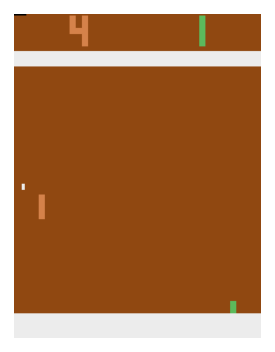

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)